In [36]:
# Installed with pip
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Included in python 3.10.0
import numpy as np
import random
import math

# Visualizations
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
data_path_pairs = []
data_path_pairs.append(('iris' , '../data/iris.csv'))
data_path_pairs.append(('wine' , '../data/wine.csv'))
data_path_pairs.append(('winequality-red' , '../data/winequality-red.csv'))
data_path_pairs.append(('winequality-white' , '../data/winequality-white.csv'))
data_path_pairs.append(('abalone' , '../data/abalone.csv'))

In [4]:
imputer_pairs = []
imputer_pairs.append(('mean' , SimpleImputer(strategy='mean')))
imputer_pairs.append(('median' , SimpleImputer(strategy='median')))
imputer_pairs.append(('most_frequent' , SimpleImputer(strategy='most_frequent')))
imputer_pairs.append(('knn' , KNNImputer()))
imputer_pairs.append(('iterative' , IterativeImputer(random_state = 42, max_iter = 250)))

In [5]:
missing_percentages = [0.10, 0.15, 0.20, 0.25]

In [6]:
def getValueListFromIndexListArray(array, indexes):
    values = []
    for row, col in indexes:
        values.append(array[row, col])
    return values

def GetResultDictionaryForImputation(imputed_array, ix, true_values):
    results_per_imputer = {}

    # Get Result values
    imputed_values = getValueListFromIndexListArray(imputed_array, ix)

    # Append MAE and RMSE
    results_per_imputer['mae'] = (mean_absolute_error(true_values, imputed_values))
    results_per_imputer['rmse'] = (math.sqrt(mean_squared_error(true_values, imputed_values)))

    return results_per_imputer

In [7]:
scaler = MinMaxScaler()
results = {}

# Iterate data sets
for data_path_pair in data_path_pairs:
    results_per_dataset = {}
    
    data_name = data_path_pair[0]
    data_path = data_path_pair[1]

    # Load Data
    data_true = pd.read_csv(data_path).to_numpy()
    data_scaled = scaler.fit_transform(data_true)

    ## Get all Indexes
    ix = [(row, col) for row in range(data_scaled.shape[0]) for col in range(data_scaled.shape[1])]

    # Get true values
    true_values = getValueListFromIndexListArray(data_scaled, ix)

    for missing_percentage in missing_percentages:
        results_per_percentage = {}

        # Create Dropped Data
        data_dropped = data_scaled.copy()

        ## Inserting random nan values
        random.seed(42)
        for row, col in random.sample(ix, int(round(missing_percentage*len(ix))), ):
            data_dropped[row, col] = np.nan
        
        # # Save dropped df locally
        # pd.DataFrame(data_dropped).to_csv(f'../data/svd/{data_name}_{missing_percentage}_dropped.csv', index=None)
        
        # Iterate through Imputers
        for imputer_pair in imputer_pairs:

            # Impute
            imputer_name = imputer_pair[0]
            imputer = imputer_pair[1]
            imputed_array = imputer.fit_transform(data_dropped)

            results_per_percentage[imputer_name] = GetResultDictionaryForImputation(imputed_array, ix, true_values)
        
        # Add SVD Results
        svd_imputed_array = pd.read_csv(f'../data/svd/{data_name}_{missing_percentage}_imputed.csv', index_col=0).to_numpy()
        results_per_percentage['svd'] = GetResultDictionaryForImputation(svd_imputed_array, ix, true_values)
        
        results_per_dataset[missing_percentage] = (results_per_percentage)
    
    results[data_name] = results_per_dataset


In [8]:
results['iris']

{0.1: {'mean': {'mae': 0.021708126417943313, 'rmse': 0.0844547082111173},
  'median': {'mae': 0.02362445072190835, 'rmse': 0.09319324465803813},
  'most_frequent': {'mae': 0.02461785938480854, 'rmse': 0.108065503281979},
  'knn': {'mae': 0.007312460765850597, 'rmse': 0.03198552443223404},
  'iterative': {'mae': 0.007959949887017906, 'rmse': 0.031932083795739044},
  'svd': {'mae': 0.01305158391548032, 'rmse': 0.06251261822500481}},
 0.15: {'mean': {'mae': 0.0312846372663869, 'rmse': 0.09874734783902572},
  'median': {'mae': 0.033265458254865043, 'rmse': 0.10723451201918283},
  'most_frequent': {'mae': 0.03962688323917137, 'rmse': 0.13501179708135153},
  'knn': {'mae': 0.01368047708725675, 'rmse': 0.04682911081741574},
  'iterative': {'mae': 0.012863322683347323, 'rmse': 0.042501139635590136},
  'svd': {'mae': 0.023182909911519767, 'rmse': 0.09114978788372181}},
 0.2: {'mean': {'mae': 0.04188951663527935, 'rmse': 0.11488468840147235},
  'median': {'mae': 0.04418628374136849, 'rmse': 0.12

In [9]:
plot_results = {}
for dataset in results:

    # Seperating mae and rmse values
    mae_df = pd.DataFrame(columns=missing_percentages)
    rmse_df = pd.DataFrame(columns=missing_percentages)
    for percentage in results[dataset]:

        for method in results[dataset][percentage]:

            mae_val = results[dataset][percentage][method]['mae']
            rmse_val = results[dataset][percentage][method]['rmse']

            mae_df.loc[method, percentage] = mae_val
            rmse_df.loc[method, percentage] = rmse_val
    
    plot_results[dataset] = [mae_df, rmse_df]

In [10]:
plot_results['iris']

[                   0.10      0.15      0.20      0.25
 mean           0.021708  0.031285   0.04189  0.052261
 median         0.023624  0.033265  0.044186  0.053158
 most_frequent  0.024618  0.039627  0.056949    0.0731
 knn            0.007312   0.01368  0.018946  0.025454
 iterative       0.00796  0.012863  0.016722  0.021883
 svd            0.013052  0.023183  0.034329  0.048341,
                    0.10      0.15      0.20      0.25
 mean           0.084455  0.098747  0.114885   0.12759
 median         0.093193  0.107235  0.124922  0.135102
 most_frequent  0.108066  0.135012  0.165878  0.191232
 knn            0.031986  0.046829  0.056867  0.071105
 iterative      0.031932  0.042501  0.049484  0.058308
 svd            0.062513   0.09115  0.117354  0.141956]

In [29]:
results_simplified = pd.DataFrame(columns=['mean', 'median', 'most_frequent', 'knn', 'iterative', 'svd'])

# Take mean of values of different missing percentage type
# Using only mean average error values
for dataset in plot_results:
    for index, row in plot_results[dataset][0].iterrows():
        results_simplified.loc[dataset, index] = statistics.mean([row[0.1], row[0.15], row[0.2], row[0.25]])

results_simplified.rename(index={'winequality-red':'wq-red', 'winequality-white':'wq-white'}, inplace=True)
results_simplified.rename(columns={'mean':'Mean', 'median':'Median', 'most_frequent': 'Most frequent', 'knn':'KNN', 'iterative':'MICE', 'svd':'SVD'}, inplace=True)

results_simplified

,Mean,Median,Most frequent,KNN,MICE,SVD
iris,0.036786,0.038558,0.048574,0.016348,0.014857,0.029726
wine,0.030035,0.029177,0.031152,0.018342,0.02285,0.0241
wq-red,0.017636,0.01712,0.020237,0.012586,0.012869,0.017137
wq-white,0.014009,0.013801,0.015059,0.01046,0.010425,0.01428
abalone,0.019055,0.018986,0.021463,0.005794,0.004432,0.006907


In [31]:
# Plot font
fontdict={
    'family':'Tahoma',
    'color':'black',
    'weight':'semibold',
    'size': 12
    }

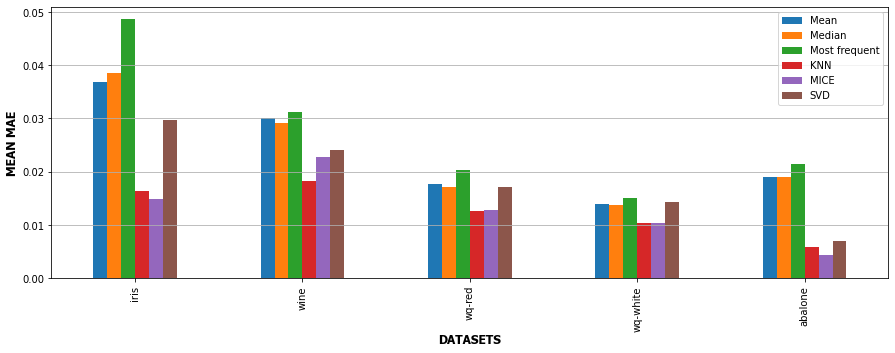

In [37]:
results_simplified.plot(kind="bar", figsize=(15, 5))
plt.grid(visible=True, axis='y')
plt.ylabel("MEAN MAE", fontdict=fontdict)
plt.xlabel("DATASETS", fontdict=fontdict)
plt.show()

In [14]:
small_yticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
medium_yticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
large_yticks = [0, 0.04, 0.08, 0.12, 0.16, 0.2]

def PlotResultDataframe(df, title, xLabel, yLabel):
    percentageList = df.columns.tolist()
    meanData = df.loc['mean'].tolist()
    medianData = df.loc['median'].tolist()
    mfData = df.loc['most_frequent'].tolist()
    knnData = df.loc['knn'].tolist()
    iterativeData = df.loc['iterative'].tolist()
    svdData = df.loc['svd'].tolist()

    # Determine yTicks by using max value
    maxValue = max(meanData)
    maxValue = max(medianData) if max(medianData) > maxValue else maxValue
    maxValue = max(mfData) if max(mfData) > maxValue else maxValue
    maxValue = max(knnData) if max(knnData) > maxValue else maxValue
    maxValue = max(iterativeData) if max(iterativeData) > maxValue else maxValue
    maxValue = max(svdData) if max(svdData) > maxValue else maxValue
    
    yticks = large_yticks
    if maxValue < max(medium_yticks): yticks = medium_yticks
    if maxValue < max(small_yticks): yticks = small_yticks

    plt.plot(percentageList, meanData,   label = 'Mean', marker='o', linewidth=3)
    plt.plot(percentageList, medianData,   label = 'Median',  marker='o', linewidth=3)
    plt.plot(percentageList, mfData, label = 'Most Frequent', marker='o', linewidth=3)
    plt.plot(percentageList, knnData, label = 'KNN', marker='o', linewidth=3)
    plt.plot(percentageList, iterativeData, label = 'MICE', marker='o', linewidth=3)
    plt.plot(percentageList, svdData, label = 'SVD', marker='o', linewidth=3)

    plt.xlabel(xlabel=xLabel, fontdict=fontdict)
    plt.ylabel(ylabel=yLabel,fontdict=fontdict)
    plt.legend(loc='upper left')
    plt.xticks(missing_percentages)
    plt.yticks(yticks)    
    plt.title(title, fontdict=fontdict)
    plt.grid(visible=True)
    plt.show()

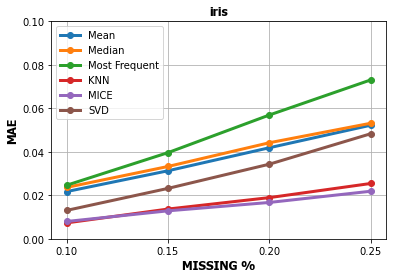

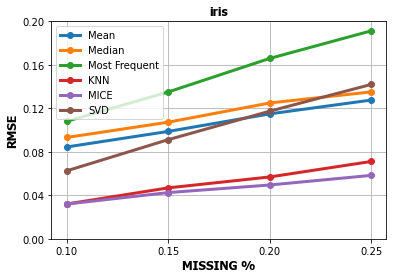

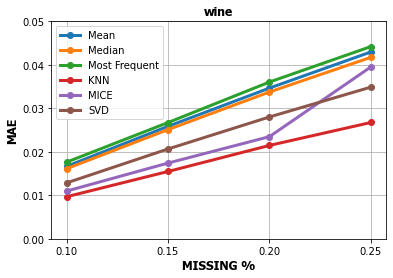

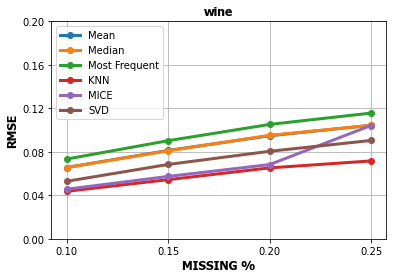

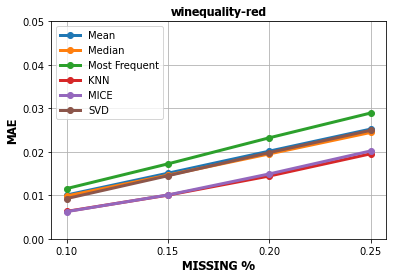

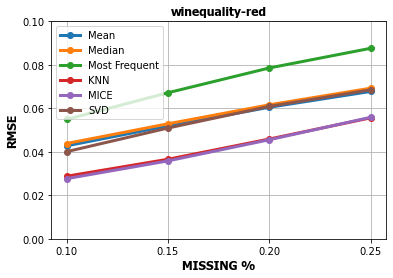

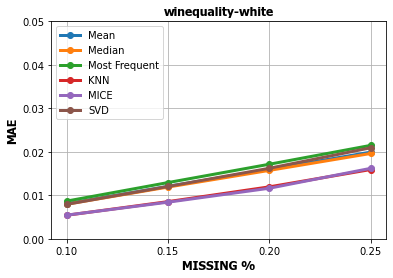

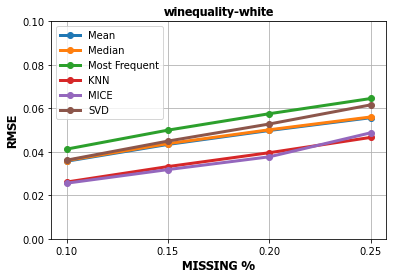

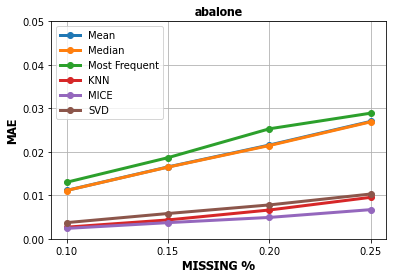

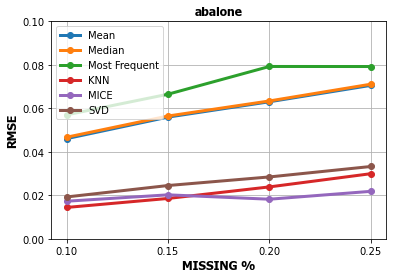

In [15]:
for dataset in plot_results:
    PlotResultDataframe(plot_results[dataset][0], dataset, "MISSING %", "MAE")
    PlotResultDataframe(plot_results[dataset][1], dataset, "MISSING %", "RMSE")